# Benchmarking Foundation Models Notebook 

Authors:
- Helio Halperin (heliohalperin@gmail.com)
- Simon Lee (simonlee711@g.ucla.edu)

2024

In [2]:
# !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.21.0
# !pip install fastprogress
# !pip install lightgbm

In [3]:
!pwd

/Users/helio/antibiotics-fm-benchmark


In [1]:
# Basic imports
import numpy as np
import pandas as pd
import json
import pickle
import torch
import torch.nn as nn

# AWS imports
# import boto3
# from sagemaker import get_execution_role

# I/O imports
from io import StringIO

# Progress and visualization imports
from tqdm.auto import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Sklearn metrics imports
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# Transformers imports
from transformers import (AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, 
    DataCollatorWithPadding, TrainingArguments, Trainer, TextClassificationPipeline, 
    AdamW, get_scheduler
)
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets, load_metric

# PyTorch data handling
from torch.utils.data import DataLoader

from scripts.train_test_split import custom_train_test_split
from scripts.encoder import encode_texts
from scripts.train_test import evaluate_antibiotics_with_confidence_intervals, print_results
from scripts.plot import plot_roc_curves, plot_auprc_curves, calculate_confidence_interval

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# read in data

In [12]:
data = pd.read_csv("./data/antibiotics_labels.csv")
display(data)

,subject_id,stay_id,hadm_id,arrival,triage,medrecon,vitals,codes,pyxis,patient_paragraph,...,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,LEVOFLOXACIN,NITROFURANTOIN,OXACILLIN,RIFAMPIN,TETRACYCLINE,TRIMETHOPRIM/SULFA,VANCOMYCIN
0,10002443,33425241,21329021,"Patient 10002443, a 53 year old white male, ar...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2183-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10002443, a 53 year old white male, ar...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,10005858,39055405,29352282,"Patient 10005858, a 62 year old white female, ...","At triage: temperature was 102.7, pulse was 93...",The patient was previously taking the followin...,The patient had the following vitals: At 2172-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10005858, a 62 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,10014078,38676365,25809882,"Patient 10014078, a 60 year old unable to obta...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014078, a 60 year old unable to obta...",...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,10014729,37887480,23300884,"Patient 10014729, a 21 year old white - other ...","At triage: temperature was 99.1, pulse was 90....",The patient was previously taking the followin...,The patient had the following vitals: At 2125-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 10014729, a 21 year old white - other ...",...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,19989126,35420737,22853928,"Patient 19989126, a 45 year old asian female, ...","At triage: temperature was not recorded, pulse...",The patient did not receive any medications re...,The patient had no vitals recorded.,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19989126, a 45 year old asian female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5978,19990821,35896332,27777812,"Patient 19990821, a 70 year old unknown male, ...","At triage: temperature was not recorded, pulse...",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient has no diagnostic codes recorded.,The patient received the following medications...,"Patient 19990821, a 70 year old unknown male, ...",...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5979,19991805,34001852,23646288,"Patient 19991805, a 80 year old white female, ...","At triage: temperature was 97.9, pulse was 67....",The patient was previously taking the followin...,The patient had the following vitals: At 2143-...,The patient received the following diagnostic ...,The patient received the following medications...,"Patient 19991805, a 80 year old white female, ...",...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5980,19994772,37554330,29199248,"Patient 19994772, a 54 year old white female, ...","At triage: temperature was 96.7, pulse was 79....",The patient was previously taking the followin...,The patient had the following vitals: At 2181-...,The patient received the following diagnostic ...

In [10]:
# List of antibiotics we are interested in
############################################
## We may or may not study NITROFURANTOIN ## 
## Because only 6% of patients were       ##
## prescribed it                          ##
############################################

antibiotics = ['CLINDAMYCIN', 'ERYTHROMYCIN', 'GENTAMICIN', 'LEVOFLOXACIN', 
               'OXACILLIN', 'TETRACYCLINE', 'TRIMETHOPRIM/SULFA', 
               'VANCOMYCIN']

In [11]:
# # Split data into 80% and 20$ cuts
train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

print('TRAIN:', len(train), 'TEST:', len(test))

TRAIN: 4844 TEST: 599


# DistilBERT (baseline)

In [17]:
# Generate Embeddings for each set of data
## We can plug in any models found on the huggingface platform
##
X_train = encode_texts('distilbert-base-uncased', train['patient_paragraph'].tolist())
X_test = encode_texts('distilbert-base-uncased', test['patient_paragraph'].tolist())

In [18]:

## Evaluate 
distilbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)



# pickle files. Saving variables into pickle files. Save all your results in these special files. 

Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


/Users/helio/antibiotics-fm-benchmark/scripts/train_test.py:100: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:18<02:10, 18.68s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


/Users/helio/antibiotics-fm-benchmark/scripts/train_test.py:100: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [00:37<01:51, 18.62s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [01:03<01:50, 22.12s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [01:24<01:26, 21.64s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [01:40<00:59, 19.75s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [01:53<00:34, 17.47s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [02:07<00:16, 16.10s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [02:20<00:00, 17.62s/it]


In [2]:
import pickle
def save_pickle(results, filename):
    """
    Creates a new pickle file

    results: the name of the variable
    filename: the name of the file
    """
    filename = f"{filename}.pickle"

    file_path=f'./results/{filename}'
    with open(file_path, 'wb') as file:
        pickle.dump(results, file)

    print(f"The variable {filename} has been saved successfully.")

def load_pickle(filename):
    """
    Loads in the pickle file

    filename: the name of the file
    """
    file_path=f'./results/{filename}.pickle'
    loaded_data = None
    with open(file_path, 'rb') as file:
        loaded_data = pickle.load(file)

    print(f"The variable {filename} has been loaded successfully.")
    print("Loaded Data:", loaded_data)

    return loaded_data


In [8]:
distilbert_results = load_pickle('DistilBERT')

The variable DistilBERT has been loaded successfully.
Loaded Data: {'CLINDAMYCIN': {'Optimal Threshold': 0.057598352797596515, 'Test Metrics': {'F1 Score': 0.7772511848341233, 'Matthews Correlation Coefficient': 0.37137918002956366, 'ROC AUC': 0.740766073871409, 'PRC AUC': 0.7708093258508101, 'fpr': array([0.        , 0.00392157, 0.00392157, 0.00784314, 0.00784314,
       0.00784314, 0.00784314, 0.01176471, 0.01176471, 0.01568627,
       0.01568627, 0.01568627, 0.01568627, 0.01568627, 0.01960784,
       0.01960784, 0.02352941, 0.02352941, 0.02745098, 0.02745098,
       0.03137255, 0.03137255, 0.03529412, 0.03529412, 0.03921569,
       0.03921569, 0.04313725, 0.04313725, 0.04705882, 0.04705882,
       0.05098039, 0.05098039, 0.05490196, 0.05490196, 0.05490196,
       0.05490196, 0.0627451 , 0.0627451 , 0.06666667, 0.06666667,
       0.0745098 , 0.0745098 , 0.07843137, 0.07843137, 0.08235294,
       0.08235294, 0.08627451, 0.08627451, 0.09019608, 0.09019608,
       0.09411765, 0.09411765

# Biomegatron

In [13]:
X_train = encode_texts('EMBO/BioMegatron345mUncased', train['patient_paragraph'].tolist())
X_test = encode_texts('EMBO/BioMegatron345mUncased', test['patient_paragraph'].tolist())
## Make sure to rename
biomegatron_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biomegatron_results)

save_pickle(biomegatron_results, "biomegatron")
biomegatron_results = load_pickle('biomegatron')

# Took too long, should use AWS

Some weights of MegatronBertModel were not initialized from the model checkpoint at EMBO/BioMegatron345mUncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

# Medbert

In [14]:
X_train = encode_texts("Charangan/MedBERT", train['patient_paragraph'].tolist())
X_test = encode_texts("Charangan/MedBERT", test['patient_paragraph'].tolist())
## Make sure to rename
medbert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(medbert_results)

save_pickle(medbert_results, "medBERT")
medbert_results = load_pickle('medBERT')

Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:16<01:56, 16.67s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [00:32<01:37, 16.32s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [00:49<01:23, 16.67s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [01:04<01:03, 15.94s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [01:18<00:45, 15.30s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


/Users/helio/antibiotics-fm-benchmark/scripts/train_test.py:100: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [01:33<00:30, 15.06s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [01:47<00:14, 14.87s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [02:03<00:00, 15.45s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7798 +/- 0.0289, MCC: 0.3691, ROC-AUC: 0.7422 +/- 0.0399, PRC-AUC: 0.7734 +/- 0.0454
Results for ERYTHROMYCIN:
  Test - F1: 0.6554 +/- 0.0423, MCC: 0.3620, ROC-AUC: 0.7549 +/- 0.0380, PRC-AUC: 0.6915 +/- 0.0596
Results for GENTAMICIN:
  Test - F1: 0.9773 +/- 0.0084, MCC: 0.3969, ROC-AUC: 0.7308 +/- 0.1110, PRC-AUC: 0.9733 +/- 0.0173
Results for LEVOFLOXACIN:
  Test - F1: 0.8103 +/- 0.0285, MCC: 0.4205, ROC-AUC: 0.7794 +/- 0.0372, PRC-AUC: 0.8222 +/- 0.0428
Results for OXACILLIN:
  Test - F1: 0.7849 +/- 0.0305, MCC: 0.4132, ROC-AUC: 0.7709 +/- 0.0347, PRC-AUC: 0.7972 +/- 0.0426
Results for TETRACYCLINE:
  Test - F1: 0.9039 +/- 0.0189, MCC: 0.3718, ROC-AUC: 0.6458 +/- 0.0608, PRC-AUC: 0.8479 +/- 0.0432
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9097 +/- 0.0178, MCC: 0.4151, ROC-AUC: 0.7228 +/- 0.0537, PRC-AUC: 0.8983 +/- 0.0293
Results for VANCOMYCIN:
  Test - F1: 0.7310 +/- 0.0355, MCC: 0.3552, ROC-AUC: 0.7593 +/- 0.0368, PRC-AUC: 0.7910 +/- 0

Biobert

In [17]:
X_train = encode_texts("pritamdeka/BioBert-PubMed200kRCT", train['patient_paragraph'].tolist())
X_test = encode_texts("pritamdeka/BioBert-PubMed200kRCT", test['patient_paragraph'].tolist())
## Make sure to rename
biobert_results = evaluate_antibiotics_with_confidence_intervals(X_train, X_test, train, test, antibiotics, n_bootstraps=1000)
print_results(biobert_results)

save_pickle(biobert_results, "BioBERT")
biobert_results = load_pickle('BioBERT')

Iterating through Antibiotics Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2636, number of negative: 2208
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544178 -> initscore=0.177175
[LightGBM] [Info] Start training from score 0.177175


Iterating through Antibiotics Progress:  12%|█▎        | 1/8 [00:17<02:05, 17.86s/it]

[LightGBM] [Info] Number of positive: 1812, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374071 -> initscore=-0.514791
[LightGBM] [Info] Start training from score -0.514791


Iterating through Antibiotics Progress:  25%|██▌       | 2/8 [00:34<01:43, 17.20s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.948183 -> initscore=2.906836
[LightGBM] [Info] Start training from score 2.906836


Iterating through Antibiotics Progress:  38%|███▊      | 3/8 [00:51<01:25, 17.15s/it]

[LightGBM] [Info] Number of positive: 2898, number of negative: 1946
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.598266 -> initscore=0.398245
[LightGBM] [Info] Start training from score 0.398245


Iterating through Antibiotics Progress:  50%|█████     | 4/8 [01:06<01:05, 16.35s/it]

[LightGBM] [Info] Number of positive: 2719, number of negative: 2125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561313 -> initscore=0.246492
[LightGBM] [Info] Start training from score 0.246492


/Users/helio/antibiotics-fm-benchmark/scripts/train_test.py:100: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
Iterating through Antibiotics Progress:  62%|██████▎   | 5/8 [01:21<00:46, 15.60s/it]

[LightGBM] [Info] Number of positive: 3755, number of negative: 1089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.775186 -> initscore=1.237828
[LightGBM] [Info] Start training from score 1.237828


Iterating through Antibiotics Progress:  75%|███████▌  | 6/8 [01:37<00:31, 15.82s/it]

[LightGBM] [Info] Number of positive: 3678, number of negative: 1166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.759290 -> initscore=1.148790
[LightGBM] [Info] Start training from score 1.148790


Iterating through Antibiotics Progress:  88%|████████▊ | 7/8 [01:52<00:15, 15.72s/it]

[LightGBM] [Info] Number of positive: 2559, number of negative: 2285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 4844, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528282 -> initscore=0.113251
[LightGBM] [Info] Start training from score 0.113251


Iterating through Antibiotics Progress: 100%|██████████| 8/8 [02:08<00:00, 16.01s/it]

Results for CLINDAMYCIN:
  Test - F1: 0.7778 +/- 0.0285, MCC: 0.3731, ROC-AUC: 0.7060 +/- 0.0420, PRC-AUC: 0.7369 +/- 0.0543
Results for ERYTHROMYCIN:
  Test - F1: 0.6483 +/- 0.0399, MCC: 0.3309, ROC-AUC: 0.7356 +/- 0.0386, PRC-AUC: 0.6598 +/- 0.0638
Results for GENTAMICIN:
  Test - F1: 0.9777 +/- 0.0085, MCC: 0.3813, ROC-AUC: 0.7035 +/- 0.1273, PRC-AUC: 0.9642 +/- 0.0225
Results for LEVOFLOXACIN:
  Test - F1: 0.8106 +/- 0.0280, MCC: 0.4318, ROC-AUC: 0.7678 +/- 0.0392, PRC-AUC: 0.8086 +/- 0.0463
Results for OXACILLIN:
  Test - F1: 0.7882 +/- 0.0302, MCC: 0.4197, ROC-AUC: 0.7742 +/- 0.0373, PRC-AUC: 0.7857 +/- 0.0517
Results for TETRACYCLINE:
  Test - F1: 0.9035 +/- 0.0184, MCC: 0.3718, ROC-AUC: 0.6365 +/- 0.0605, PRC-AUC: 0.8487 +/- 0.0394
Results for TRIMETHOPRIM/SULFA:
  Test - F1: 0.9083 +/- 0.0182, MCC: 0.4099, ROC-AUC: 0.7219 +/- 0.0557, PRC-AUC: 0.8909 +/- 0.0356
Results for VANCOMYCIN:
  Test - F1: 0.7306 +/- 0.0344, MCC: 0.3447, ROC-AUC: 0.7580 +/- 0.0367, PRC-AUC: 0.7699 +/- 0

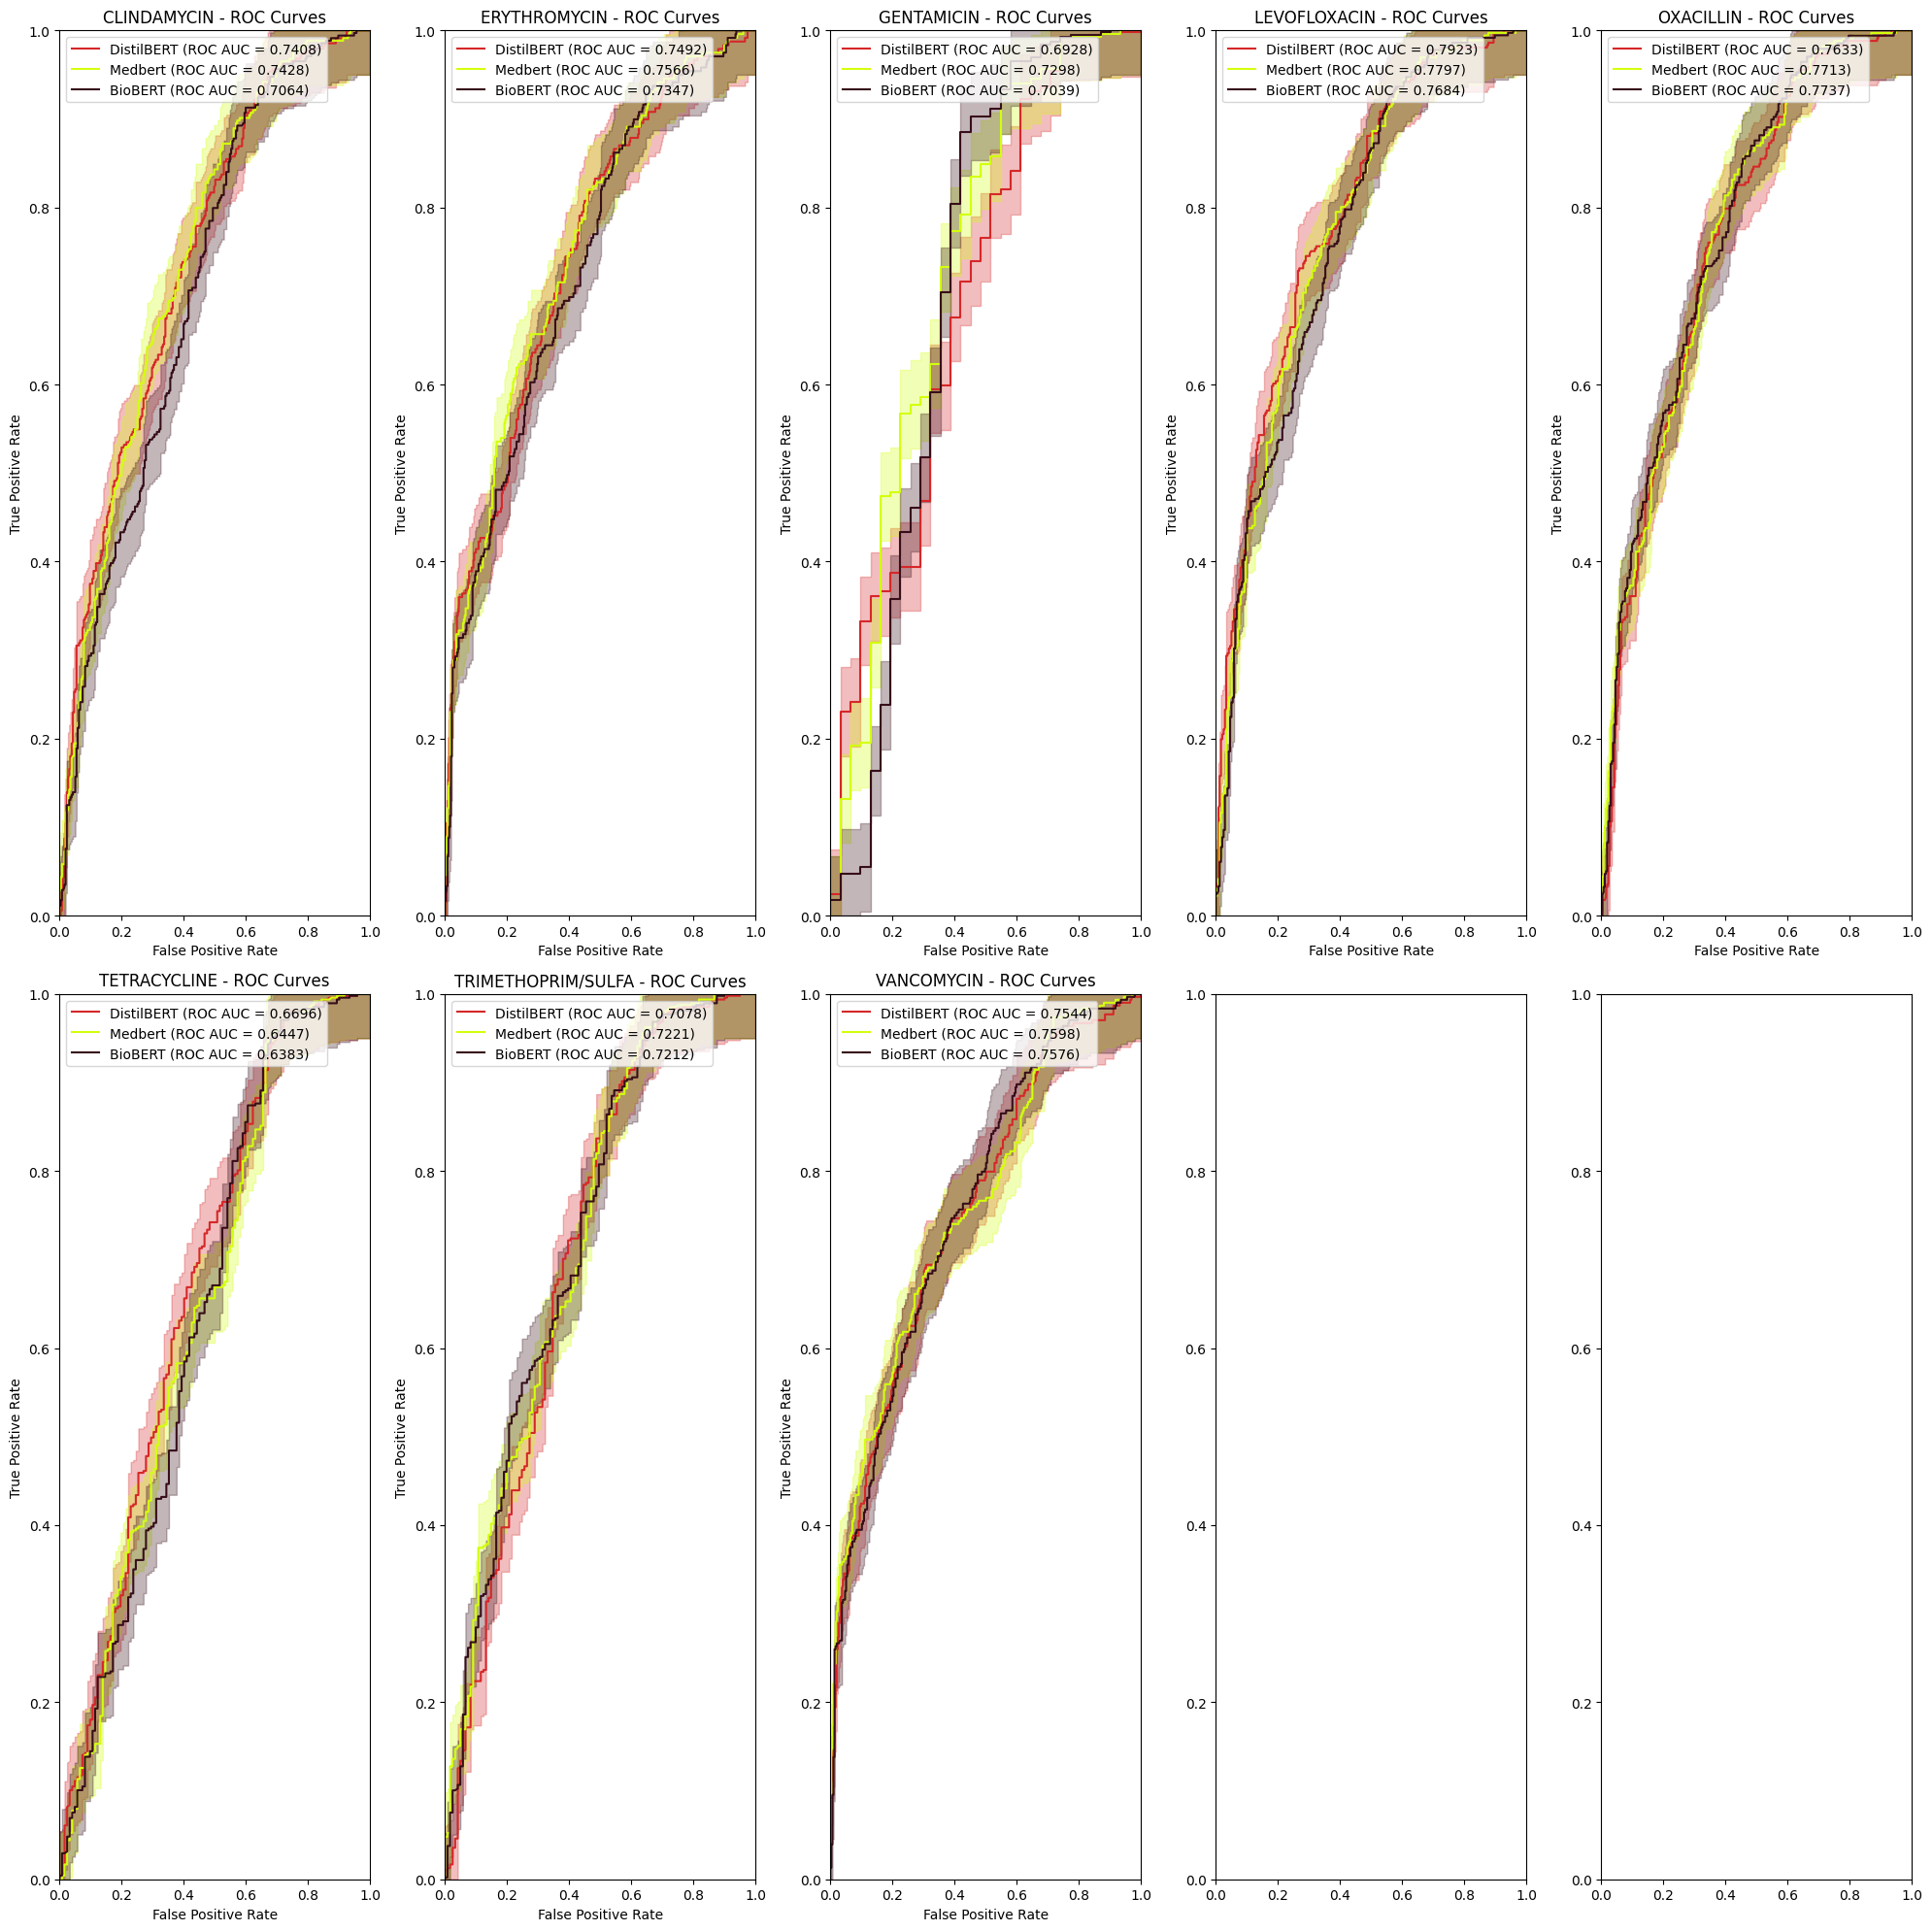

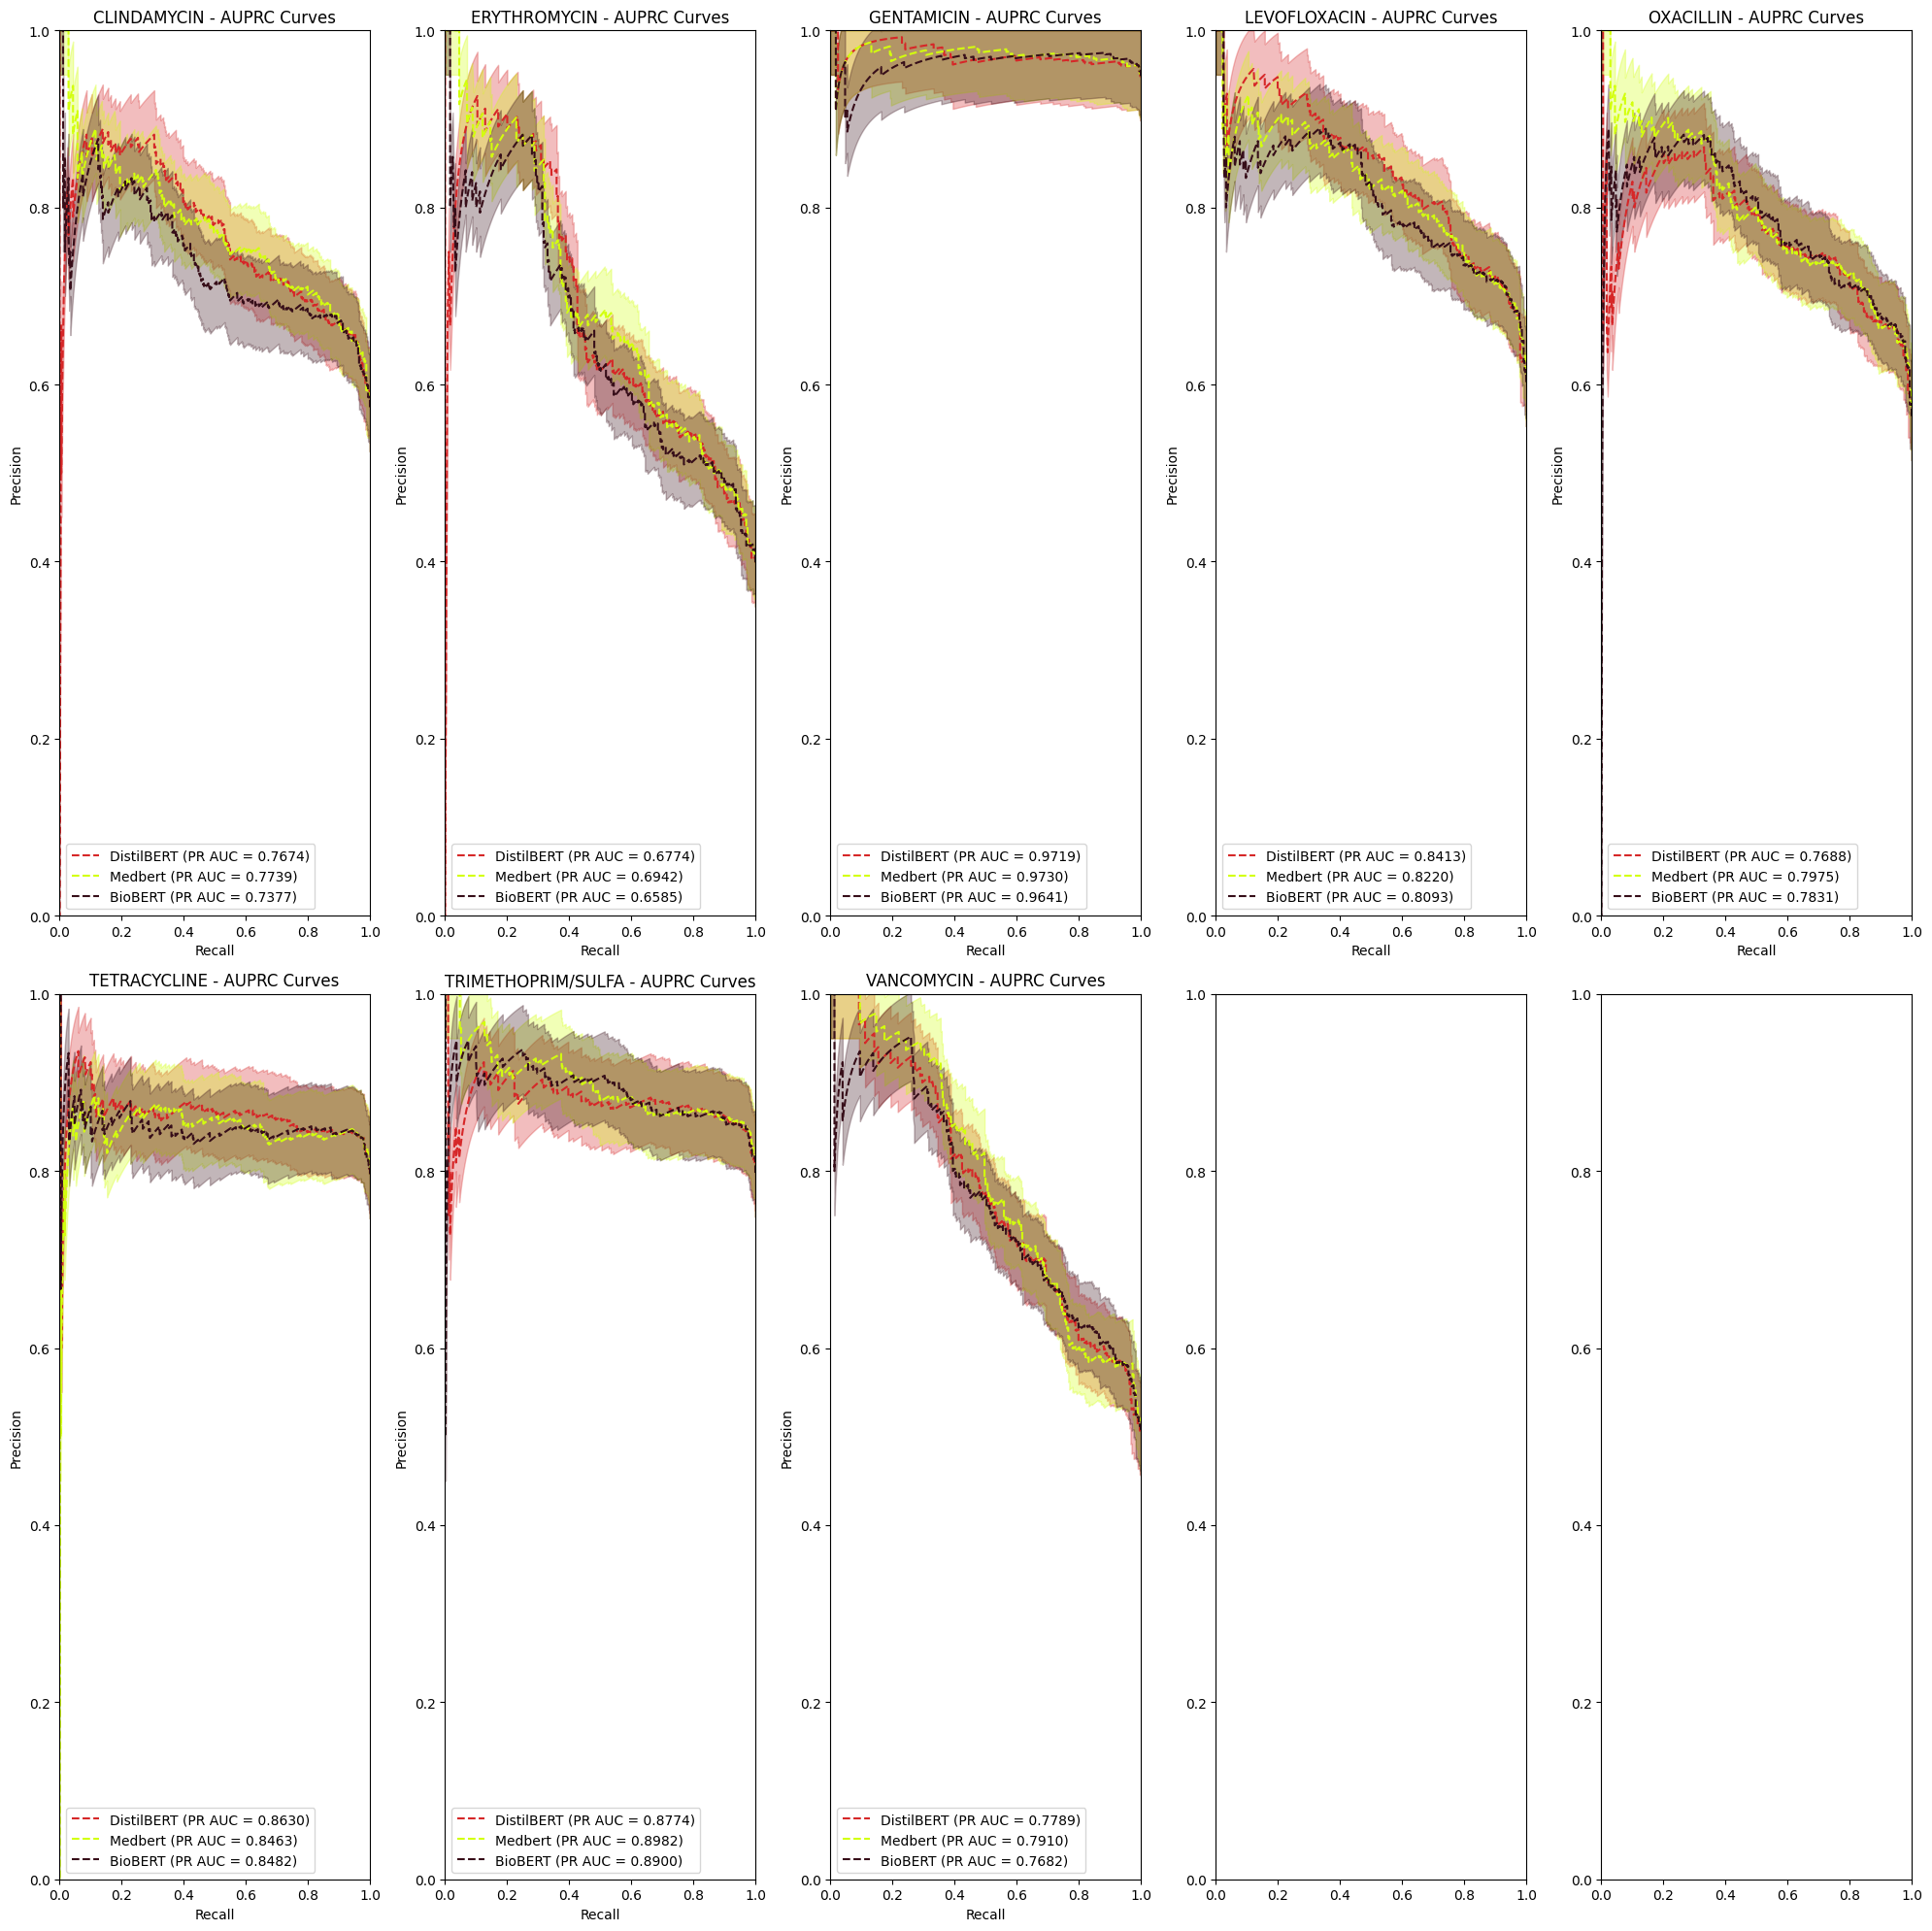

In [23]:
model_colors = {
    "DistilBERT": '#d62728',
    #"BioMegatron": '#9467bd',
    "Medbert": "#d3ff0d",
    "BioBERT": "#370e19"
}

# Dictionaries with their corresponding model names
dictionaries = [
    (distilbert_results, "DistilBERT"),
    # (biomegatron_results, "BioMegatron"),
    (medbert_results, "Medbert"),
    (biobert_results, "BioBERT")
]
plot_roc_curves(antibiotics, dictionaries, model_colors)
plot_auprc_curves(antibiotics, dictionaries, model_colors)